In [1]:
# ideas for a source test
import cobra
import pandas as pd

from refinegems.utility.io import load_model

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')


-----
### Plot the basic analysis

- one model  -  done more or less
- collection of models

#### Plot for a single report

In [1]:
from refinegems.utility.io import load_model
from refinegems.classes.reports import ModelInfoReport
import matplotlib.pyplot as plt

test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

rep = ModelInfoReport(test_model)
fig = rep.visualise()

plt.show()

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H14NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarn

### Testing Growth (for Tobias)

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


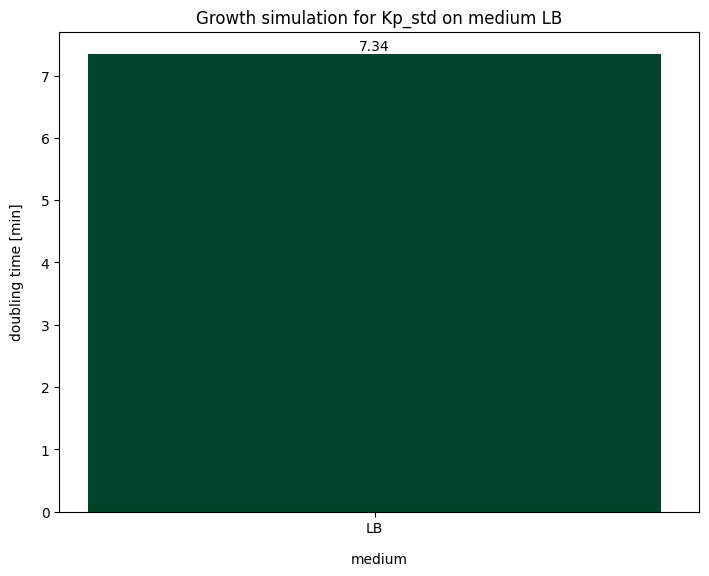

In [1]:
# TESTING for Tobias - this stays for a bit 
from refinegems.utility.io import load_model
from refinegems.analysis.growth import growth_analysis
from refinegems.classes.medium import load_medium_from_db


test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

m = load_medium_from_db('LB')
l = load_medium_from_db('SNM3')
test = growth_analysis(test_model,[m,l], retrieve='plot')

In [5]:
test.plot_growth()

IndexError: Can only plot growth if at least one model and one medium are present.